In [1]:
import numpy as np
import pandas
import torch
import neuralnetworks_torch as nntorch
import os
import time
import matplotlib.pyplot as plt
import sklearn
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import scipy
from scipy.spatial.distance import cosine as cos_dist

In [2]:
class CNN1D(torch.nn.Module):

    def __init__(self, n_inputs, n_channels, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                 patch_size_per_conv_layer, stride_per_conv_layer, activation_function='tanh', device='cpu'):

        super().__init__()

        self.device = device

        n_conv_layers = len(n_hiddens_per_conv_layer)
        if (len(patch_size_per_conv_layer) != n_conv_layers
            or len(stride_per_conv_layer) != n_conv_layers):
            raise Exception('The lengths of n_hiddens_per_conv_layer, patch_size_per_conv_layer, and stride_per_conv_layer must be equal.')

        self.activation_function = torch.tanh if activation_function == 'tanh' else torch.relu

        self.make_conv_and_fc_layers(n_inputs, n_channels, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                                     patch_size_per_conv_layer, stride_per_conv_layer)
        
        self.Xmeans = None
        self.to(self.device)

    def make_conv_and_fc_layers(self, n_inputs, n_channels, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer,
                                n_outputs, patch_size_per_conv_layer, stride_per_conv_layer):
        # Create all convolutional layers
        # First argument to first Conv2d is number of channels for each pixel.
        # Just 1 for our grayscale images.
        n_in = n_channels
        input_hw = n_inputs  # original input image height (=width because image assumed square)
        self.conv_layers = torch.nn.ModuleList()
        layeri = 0
        for nh, patch_size, stride in zip(n_hiddens_per_conv_layer,
                                          patch_size_per_conv_layer,
                                          stride_per_conv_layer):
            self.conv_layers.append(torch.nn.Conv1d(n_in, nh, kernel_size=patch_size, stride=stride))
            conv_layer_output_hw = (input_hw - patch_size) // stride + 1
            print(input_hw,patch_size,stride,conv_layer_output_hw)
            if conv_layer_output_hw <= 0:
                raise Exception(f'''For conv layer {layeri}, input_hw of {input_hw} is less than patch_size {patch_size}.
Try reducing the patch_size for this layer or for the previous layer.''')
            input_hw = conv_layer_output_hw  # for next trip through this loop
            n_in = nh
            layeri += 1
           
        # Create all fully connected layers.  First must determine number of inputs to first
        # fully-connected layer that results from flattening the images coming out of the last
        # convolutional layer.
        n_in = input_hw * n_in
        self.fc_layers = torch.nn.ModuleList()
        for nh in n_hiddens_per_fc_layer:
            self.fc_layers.append(torch.nn.Linear(n_in, nh))
            n_in = nh
        self.fc_layers.append(torch.nn.Linear(n_in, n_outputs))

    def forward_all_outputs(self, X):
        n_samples = X.shape[0]
        Ys = [X]
        for conv_layer in self.conv_layers:
            Ys.append(self.activation_function(conv_layer(Ys[-1])))

        flattened_input = Ys[-1].reshape(n_samples, -1)

        for layeri, fc_layer in enumerate(self.fc_layers[:-1]):
            if layeri == 0:
                Ys.append(self.activation_function(fc_layer(flattened_input)))
            else:
                Ys.append(self.activation_function(fc_layer(Ys[-1])))

        if len(self.fc_layers) == 1:
            # only the output layer
            Ys.append(self.fc_layers[-1](flattened_input))
        else:
            Ys.append(self.fc_layers[-1](Ys[-1]))

        return Ys

    def forward(self, X):
        Ys = self.forward_all_outputs(X)
        return Ys[-1]

    def train(self, X, T, batch_size, n_epochs, learning_rate, method='sgd', verbose=True):
        '''X and T must be numpy arrays'''

        self.classes = np.unique(T)
        T = np.arange(len(self.classes))[np.where(T.reshape(-1, 1) == self.classes)[1]]

        # Set data matrices to torch.tensors
        X = torch.from_numpy(X).float().to(self.device)
        T = torch.from_numpy(T).long().to(self.device)  # required for classification in pytorch

        # Setup standardization parameters
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xstds[self.Xstds == 0] = 1  # So we don't divide by zero when standardizing

        # Standardize X
        X = (X - self.Xmeans) / self.Xstds
        
        X.requires_grad_(True)

        if method == 'sgd':
            optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate, momentum=0.9)
        else:
            optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

        CELoss = torch.nn.CrossEntropyLoss(reduction='mean')
        self.error_trace = []

        for epoch in range(n_epochs):

            num_batches = X.shape[0] // batch_size
            loss_sum = 0

            for k in range(num_batches):
                start = k * batch_size
                end = (k + 1) * batch_size
                X_batch = X[start:end, ...]
                T_batch = T[start:end, ...]

                Y = self.forward(X_batch)

                loss = CELoss(Y, T_batch)
                loss.backward()

                # Update parameters
                optimizer.step()
                optimizer.zero_grad()

                loss_sum += loss

            self.error_trace.append(loss_sum / num_batches)

            if verbose and (epoch + 1) % (max(1, n_epochs // 10)) == 0:
                print(f'{method}: Epoch {epoch + 1} Loss {self.error_trace[-1]:.3f}')

        return self

    def softmax(self, Y):
        '''Apply to final layer weighted sum outputs'''
        # Trick to avoid overflow
        maxY = torch.max(Y, axis=1)[0].reshape((-1, 1))
        expY = torch.exp(Y - maxY)
        denom = torch.sum(expY, axis=1).reshape((-1, 1))
        Y = expY / denom
        return Y

    def use(self, X):
        # Set input matrix to torch.tensors
        X = torch.from_numpy(X).float().to(self.device)
        # Standardize X
        X = (X - self.Xmeans) / self.Xstds
        # Calculate output of net for all samples in X
        Y = self.forward(X)
        # Convert output to class probabilities
        probs = self.softmax(Y)
        # For each sample pick highest probability and translate that to class labels
        classes = self.classes[torch.argmax(probs, axis=1).cpu().numpy()].reshape(-1, 1)
        return classes, probs.detach().cpu().numpy()

In [3]:
def pad(data):
    eps = np.unique(data[:,0])
    samples = data
    padded = samples.copy()
    for i in eps:
        count = np.count_nonzero(samples[:,0] == i)
        if count < 10:
            max_idx = np.max(np.where(padded[:,0] == i)[0])
            #print(i,10-count,max_idx)
            for j in range(10-count):
                #print("Inserting %s at %s" % (padded[max_idx][0], max_idx+1+j))
                padded = np.insert(padded,max_idx+1+j,padded[max_idx],axis=0)
                #print(j,padded.shape)
                
    return padded

In [4]:
def make_train_test_data(classes, crop_len, feature_idxs):
    subset = crop_len

    Xtrain = np.vstack([train_data[c][:subset] for c in classes])[:,feature_idxs]
    Ttrain = np.vstack([train_data[c][:subset] for c in classes])[:,1]
    Xtrain = Xtrain.reshape(Xtrain.shape[0],-1)

    Xtest = np.vstack([test_data[c] for c in classes])[:,feature_idxs]
    Ttest = np.vstack([test_data[c] for c in classes])[:,1]

    n_channels = Xtrain.shape[1]
    print(Xtrain.shape,Ttrain.shape,Xtest.shape,Ttest.shape)

    Xtrain = Xtrain.flatten().reshape(-1,int(Xtrain.shape[1]*10)) # group into 10s
    Ttrain = np.max(Ttrain.flatten().reshape(-1,10), axis=1)

    Xtest = Xtest.flatten().reshape(-1,int(Xtest.shape[1]*10))
    Ttest = np.max(Ttest.flatten().reshape(-1,10), axis=1)
    print(Xtrain.shape,Ttrain.shape,Xtest.shape,Ttest.shape)

    Xtrain = Xtrain.reshape(-1,1,n_channels*10)
    Xtest = Xtest.reshape(-1,1,n_channels*10)

    print(Xtrain.shape,Ttrain.shape,Xtest.shape,Ttest.shape)

    return Xtrain,Ttrain,Xtest,Ttest

In [5]:
def train_classifier(X, T, n_classes):
    gpu = True
    device = 'cpu'
    if gpu:
        if not torch.cuda.is_available():
            print("CUDA not available. Defaulting to CPU.")
        else:
            device = 'cuda:0'

    n_channels = X.shape[-1]//10
    cnn1d = CNN1D(n_channels*10, 1, [512, 256], [128, 128], n_classes, [n_channels, 4], [8, 2], device=device)

    n_epochs = 500
    batch_size = 100
    learning_rate = 0.001

    cnn1d.train(X, T, batch_size, n_epochs, learning_rate, method='adam')
    
    return cnn1d

In [6]:
# try some new data
# (load all samples from padded_data because we don't care about a balanced set for testing on new object types)
# 2 = cylinders (3 = capsules; 4 = small cubes)
def compare_classes(model, n_channels, novelty_threshold=20):
    novelty = []
    dissimilarities = []
    for i in range(5):
        new_data_class = i
        Xnew = np.vstack([padded_data[new_data_class]])[:,feature_idxs]
        Xnew = Xnew.flatten().reshape(-1,int(Xnew.shape[1]*10))
        Xnew = Xnew.reshape(-1,1,n_channels*10)

        print("New class:", new_data_class)

        # get most similar class
        classes, _ = model.use(Xnew)
        most_similar_class = int(scipy.stats.mode(classes).mode.item())
        print("Most similar class:", most_similar_class)

        # get embedding vectors of the new samples
        newYs = model.forward_all_outputs(torch.from_numpy(Xnew).float())
        new_logits = newYs[-2].detach().numpy()

        #print(np.var(new_logits, axis=0))
        #print(np.var(new_logits, axis=0).shape)
        #print("New data vector variance:", np.sum(np.var(new_logits, axis=0)))

        # get embedding vectors of the known class samples
        Xsim = np.vstack([padded_data[most_similar_class]])[:,feature_idxs]
        Xsim = Xsim.flatten().reshape(-1,int(Xsim.shape[1]*10))
        Xsim = Xsim.reshape(-1,1,n_channels*10)

        simYs = model.forward_all_outputs(torch.from_numpy(Xsim).float())
        sim_logits = simYs[-2].detach().numpy()

        #print(np.mean(new_logits, axis=0))
        #print(np.mean(sim_logits, axis=0))
        new_mean = np.mean(new_logits, axis=0)
        sim_mean = np.mean(sim_logits, axis=0)
        #print(new_mean-sim_mean)

        new_std = np.std(new_logits, axis=0)
        sim_std = np.std(sim_logits, axis=0)
        #print(sim_variance)

        print("Angle from sim_mean to sim_mean+std:",cos_dist(sim_mean,sim_mean+sim_std))
        #print("Angle from sim_mean to sim_mean-var:",cos_dist(sim_mean,sim_mean-sim_variance))
        print("Angle from sim_mean to new_mean:", cos_dist(sim_mean,new_mean))
        #print("Angle from new_mean to new_mean+std:", cos_dist(new_mean,new_mean+new_std))
        #print("Angle from sim_mean to new_mean+std:", cos_dist(sim_mean,new_mean+new_std))
        #print("Angle from sim_mean to new_mean-std:", cos_dist(sim_mean,new_mean-new_std))
        #min_diff_angle = np.min([cos_dist(sim_mean,new_mean+new_std),cos_dist(sim_mean,new_mean-new_std)])
        #max_diff_angle = np.max([cos_dist(sim_mean,new_mean+new_std),cos_dist(sim_mean,new_mean-new_std)])
        #print("Max angle from sim_mean to new_mean+/-std", max_diff_angle)
        #print("Max angle/angle from sim_mean to sim_mean+std:", max_diff_angle/cos_dist(sim_mean,sim_mean+sim_std))
        print("Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std:",\
              cos_dist(sim_mean,new_mean)/cos_dist(sim_mean,sim_mean+sim_std))
        likely_novel_class = cos_dist(sim_mean,new_mean)/cos_dist(sim_mean,sim_mean+sim_std) > 0
        #print(likely_novel_class)

        outlier_threshold = 1
        z_threshold = 3
        
        new_outliers = []
        for i in range(len(new_logits)):
            if cos_dist(sim_mean,new_logits[i])/cos_dist(sim_mean,sim_mean+sim_std) > outlier_threshold:
                #print(i,cos_dist(sim_mean,new_logits[i])/cos_dist(sim_mean,sim_mean+sim_std))
                new_outliers.append(cos_dist(sim_mean,new_logits[i])/cos_dist(sim_mean,sim_mean+sim_std))
        #print(len(new_outliers))
        #print(np.mean([new_outliers]),np.std([new_outliers]))
        new_outliers_pruned = []
        for i in range(len(new_outliers)):
            if (new_outliers[i]-np.mean([new_outliers]))/np.std([new_outliers]) < z_threshold:
                #print(new_outliers[i])
                new_outliers_pruned.append(new_outliers[i])
        #print(len(new_outliers_pruned))
        #print()
        
        sim_outliers = []
        for i in range(len(sim_logits)):
            if cos_dist(sim_mean,sim_logits[i])/cos_dist(sim_mean,sim_mean+sim_std) > outlier_threshold:
                #print(i,cos_dist(sim_mean,sim_logits[i])/cos_dist(sim_mean,sim_mean+sim_std))
                sim_outliers.append(cos_dist(sim_mean,sim_logits[i])/cos_dist(sim_mean,sim_mean+sim_std))
        #print(len(sim_outliers))
        #print(np.mean([sim_outliers]),np.std([sim_outliers]))
        sim_outliers_pruned = []
        for i in range(len(sim_outliers)):
            if (sim_outliers[i]-np.mean([sim_outliers]))/np.std([sim_outliers]) < z_threshold:
                #print(sim_outliers[i])
                sim_outliers_pruned.append(sim_outliers[i])
        #print(len(sim_outliers_pruned))
                
        #print(np.sum(new_outliers_pruned),np.sum(sim_outliers_pruned))
        outlier_ratio = np.sum(new_outliers_pruned)/np.sum(sim_outliers_pruned) \
              if np.sum(sim_outliers_pruned) > 0 else float('inf')
        print("Outlier ratio:",outlier_ratio)
        likely_novel_class = (outlier_ratio == float('inf')) if likely_novel_class else likely_novel_class
        
        dissimilarity = outlier_ratio*cos_dist(sim_mean,new_mean)/cos_dist(sim_mean,sim_mean+sim_std)*\
        np.sum(sim_outliers_pruned)
        print("Dissimilarity from most similar class:", dissimilarity)

        likely_novel_class = (dissimilarity > novelty_threshold) if not likely_novel_class else likely_novel_class
        print("Likely novel class:",likely_novel_class)
        
        print()
        
        dissimilarities.append(dissimilarity)
        novelty.append(likely_novel_class)
        
    return novelty,dissimilarities

Column key:
* Column 1 is the episode number.
* Column 2 is the theme object;  0 = big cube, 1 = sphere, 2 = cylinder, 3 = capsule, 4 = small cube.
* Column 3 is the destination object.  Always 0 because we were always stacking on a cube.
* Columns 4-6 are the rotation (4 = X; 5 = Y; 6 = Z) of the theme object at the start of the trial, in radians.
* Column 7 is the angle, theta (in radians), between the vertical upright axis in world space (0,1,0), and the normalized intrinsic upward axis of the theme object at the start of the trial.
* Columns 8, 9 are the 2-dimensions of the action that was executed.
* Columns 10-12 are the rotation of the theme object after the action was completed (same convention as 4-6), in radians.
* Column 13 is the theta angle, as in 7, but after action was completed.
* Column 14-16 is the "jitter" force applied to the object after placement (to simulate release)
* Columns 17-19 is the center of the theme object (after action completion)
* Columns 20-22 is the size of the theme object
* Column 23-25 is the observation after action completion. Here I’m using height and center of gravity so it takes up 3 columns
* Column 26 is the reward. With this model, the agent gets -1 for missing the destination object entirely, 9 for touching the destination object but the theme falls off, and up to 1000 for successful stacking (1000 on the first try, -100 for each additional attempt).
* Column 27 is the cumulative reward over the episode.
* Column 28 is the mean reward over the episode.

In [7]:
# load up data
data = {}
data[0] = pandas.read_csv('trial-data/122521-2cubes.csv', header=None)
data[0] = data[0][data[0].iloc[:,1] == 0]

data[1] = pandas.read_csv('trial-data/122521-cube_sphere.csv', header=None)
data[1] = data[1][data[1].iloc[:,1] == 1]

data[2] = pandas.read_csv('trial-data/122521-cube_cylinder.csv', header=None)
data[2] = data[2][data[2].iloc[:,1] == 2]

data[3] = pandas.read_csv('trial-data/122521-cube_capsule.csv', header=None)
data[3] = data[3][data[3].iloc[:,1] == 3]

data[4] = pandas.read_csv('trial-data/122521-bigcube_smallcube.csv', header=None)
data[4] = data[4][data[4].iloc[:,1] == 4]

In [8]:
# pad data
padded_data = {}
padded_data[0] = pad(data[0].to_numpy())
padded_data[1] = pad(data[1].to_numpy())
padded_data[2] = pad(data[2].to_numpy())
padded_data[3] = pad(data[3].to_numpy())
padded_data[4] = pad(data[4].to_numpy())

test_n = 100 # 100 test samples of each class

# split train and test
test_data = {}
test_data[0] = padded_data[0][-test_n:]
test_data[1] = padded_data[1][-test_n:]
test_data[2] = padded_data[2][-test_n:]
test_data[3] = padded_data[3][-test_n:]
test_data[4] = padded_data[4][-test_n:]

crop_len = min([len(padded_data[k]) for k in padded_data])-test_n

print(crop_len)

train_data = {}
train_data[0] = padded_data[0][:crop_len]
train_data[1] = padded_data[1][:crop_len]
train_data[2] = padded_data[2][:crop_len]
train_data[3] = padded_data[3][:crop_len]
train_data[4] = padded_data[4][:crop_len]

for k in train_data:
    print(train_data[k].shape,train_data[k])

900
(900, 28) [[   3.    0.    0. ... 1000. 1000. 1000.]
 [   3.    0.    0. ... 1000. 1000. 1000.]
 [   3.    0.    0. ... 1000. 1000. 1000.]
 ...
 [  92.    0.    0. ... 1000. 1000. 1000.]
 [  92.    0.    0. ... 1000. 1000. 1000.]
 [  92.    0.    0. ... 1000. 1000. 1000.]]
(900, 28) [[ 3.        1.        0.       ...  9.        9.        9.      ]
 [ 3.        1.        0.       ... -1.        8.        4.      ]
 [ 3.        1.        0.       ...  9.       17.        5.666667]
 ...
 [92.        1.        0.       ...  9.       42.        5.25    ]
 [92.        1.        0.       ...  9.       51.        5.666667]
 [92.        1.        0.       ...  9.       60.        6.      ]]
(900, 28) [[   3.    2.    0. ... 1000. 1000. 1000.]
 [   3.    2.    0. ... 1000. 1000. 1000.]
 [   3.    2.    0. ... 1000. 1000. 1000.]
 ...
 [  92.    2.    0. ... 1000. 1000. 1000.]
 [  92.    2.    0. ... 1000. 1000. 1000.]
 [  92.    2.    0. ... 1000. 1000. 1000.]]
(900, 28) [[ 3.        3.     

# A: Given cube and sphere

Test for the ability to infer the existence of cylinder and capsule as distinct classes while not splitting small cube from big cube.

========== Experiment 1 ==========
(1800, 19) (1800,) (200, 19) (200,)
(180, 190) (180,) (20, 190) (20,)
(180, 1, 190) (180,) (20, 1, 190) (20,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.000
adam: Epoch 100 Loss 0.000
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 1.7821788787841797e-05
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.007541537284851074
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimi

adam: Epoch 50 Loss 0.000
adam: Epoch 100 Loss 0.000
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.00036787986755371094
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 7.474422454833984e-05
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.00036787986755371094
Angle from sim_mean to new_mean: 4.1723251342773

adam: Epoch 50 Loss 0.000
adam: Epoch 100 Loss 0.000
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0007154345512390137
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.00013297796249389648
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0007154345512390137
Angle from sim_mean to new_mean: 3.57627868652343

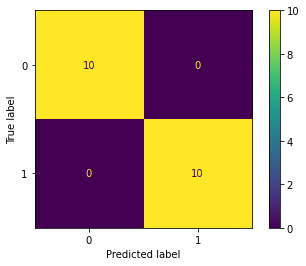

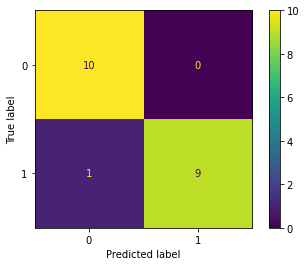

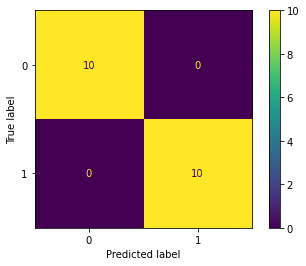

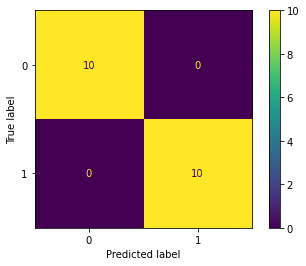

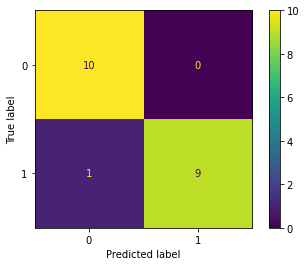

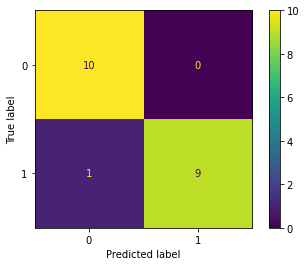

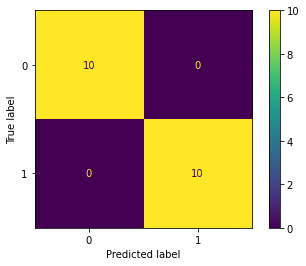

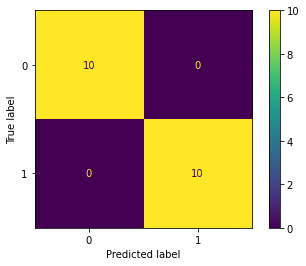

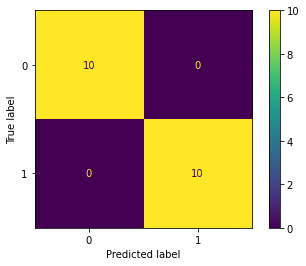

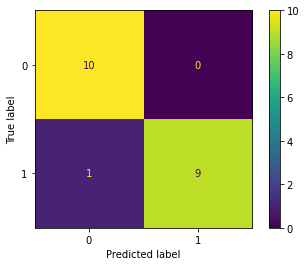

In [9]:
ground_truth = [False, False, True, True, False]
novelty_judgments = []
n_exps = 10

for i in range(n_exps):
    print("========== Experiment %s ==========" % str(i+1))
    
    feature_idxs = [*range(3,16),*range(22,28)] 
    #feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
    #feature_idxs = [*range(3,19),*range(22,28)] # with object position
    Xtrain, Ttrain, Xtest, Ttest = make_train_test_data([0,1], crop_len, feature_idxs)
    print()

    model = train_classifier(Xtrain, Ttrain, 2)
    print()

    # check classifier on the test data
    classes, probs = model.use(Xtest)

    # make confusion matrix
    cm = sklearn.metrics.confusion_matrix(Ttest, classes)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()

    novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
    novelty_judgments.append(novel_classes)
    
novelty_judgments = np.array(novelty_judgments).reshape(n_exps,-1).T

pred_acc = []
for i in range(len(ground_truth)):
    pred_acc.append(np.sum(novelty_judgments[i] == ground_truth[i])/n_exps)
    print(ground_truth[i], novelty_judgments[i], pred_acc[-1])
    
print(pred_acc, np.mean(pred_acc))

# B: Given cube, sphere, and cylinder

Test for the ability to infer the existence of capsule as a distinct class while not splitting small cube from big cube.

========== Experiment 1 ==========
(2700, 19) (2700,) (300, 19) (300,)
(270, 190) (270,) (30, 190) (30,)
(270, 1, 190) (270,) (30, 1, 190) (30,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.021
adam: Epoch 100 Loss 0.013
adam: Epoch 150 Loss 0.010
adam: Epoch 200 Loss 0.009
adam: Epoch 250 Loss 0.008
adam: Epoch 300 Loss 0.008
adam: Epoch 350 Loss 0.008
adam: Epoch 400 Loss 0.008
adam: Epoch 450 Loss 0.007
adam: Epoch 500 Loss 0.007

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0010393261909484863
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0002938508987426758
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimi

adam: Epoch 50 Loss 0.021
adam: Epoch 100 Loss 0.013
adam: Epoch 150 Loss 0.011
adam: Epoch 200 Loss 0.009
adam: Epoch 250 Loss 0.008
adam: Epoch 300 Loss 0.008
adam: Epoch 350 Loss 0.008
adam: Epoch 400 Loss 0.007
adam: Epoch 450 Loss 0.007
adam: Epoch 500 Loss 0.007

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0008364319801330566
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0008521676063537598
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 2
Angle from sim_mean to sim_mean+std: 0.0009562969207763672
Angle from sim_mean to new_mean: 0.0
Angle from si

adam: Epoch 50 Loss 0.021
adam: Epoch 100 Loss 0.013
adam: Epoch 150 Loss 0.010
adam: Epoch 200 Loss 0.009
adam: Epoch 250 Loss 0.008
adam: Epoch 300 Loss 0.008
adam: Epoch 350 Loss 0.008
adam: Epoch 400 Loss 0.007
adam: Epoch 450 Loss 0.007
adam: Epoch 500 Loss 0.007

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0008907318115234375
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0006979703903198242
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 2
Angle from sim_mean to sim_mean+std: 0.0013066530227661133
Angle from sim_mean to new_mean: 0.0
Angle from si

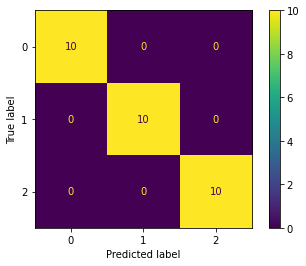

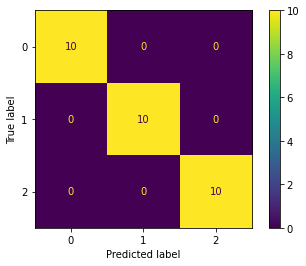

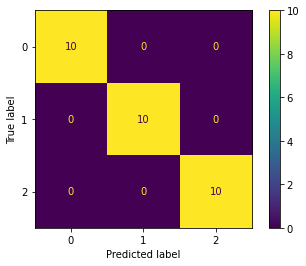

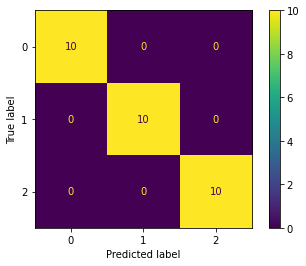

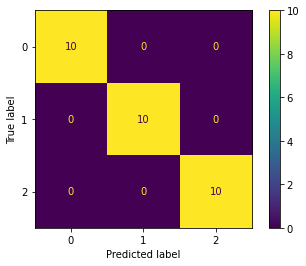

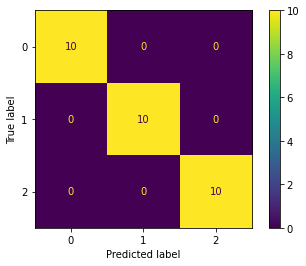

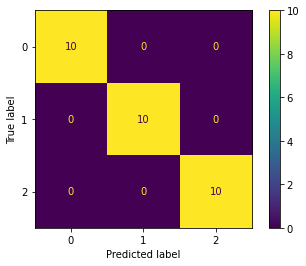

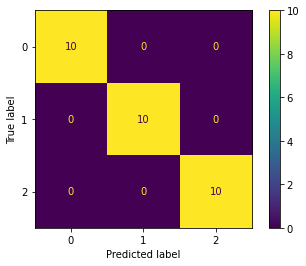

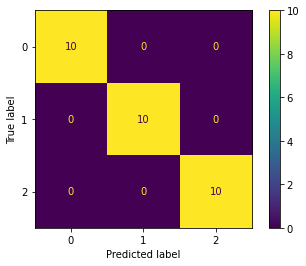

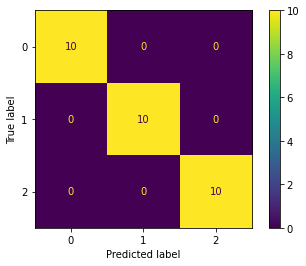

In [10]:
ground_truth = [False, False, False, True, False]
novelty_judgments = []
n_exps = 10

for i in range(n_exps):
    print("========== Experiment %s ==========" % str(i+1))

    feature_idxs = [*range(3,16),*range(22,28)]
    #feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
    #feature_idxs = [*range(3,19),*range(22,28)] # with object position
    Xtrain, Ttrain, Xtest, Ttest = make_train_test_data([0,1,2], crop_len, feature_idxs)
    print()

    model = train_classifier(Xtrain, Ttrain, 3)
    print()

    # check classifier on the test data
    classes, probs = model.use(Xtest)

    # make confusion matrix
    cm = sklearn.metrics.confusion_matrix(Ttest, classes)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()

    novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
    novelty_judgments.append(novel_classes)
    
novelty_judgments = np.array(novelty_judgments).reshape(n_exps,-1).T

pred_acc = []
for i in range(len(ground_truth)):
    pred_acc.append(np.sum(novelty_judgments[i] == ground_truth[i])/n_exps)
    print(ground_truth[i], novelty_judgments[i], pred_acc[-1])
    
print(pred_acc, np.mean(pred_acc))

# C: Given cube, sphere, and capsule

Test for the ability to infer the existence of cylinder as a distinct class while not splitting small cube from big cube.

========== Experiment 1 ==========
(2700, 19) (2700,) (300, 19) (300,)
(270, 190) (270,) (30, 190) (30,)
(270, 1, 190) (270,) (30, 1, 190) (30,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.03506028652191162
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0016175508499145508
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimila

adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.036975085735321045
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0006995201110839844
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.036975085735321045
Angle from sim_mean to new_mean: 0.00023221969604492

adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.015014588832855225
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0005079507827758789
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.015014588832855225
Angle from sim_mean to new_mean: 1.5854835510253906e

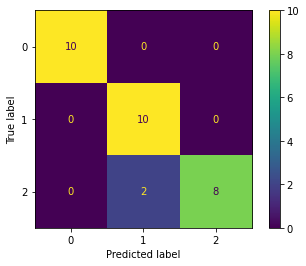

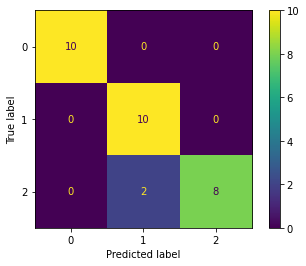

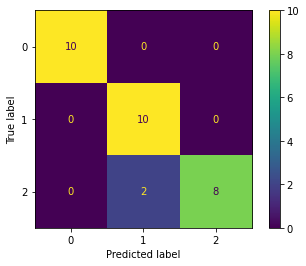

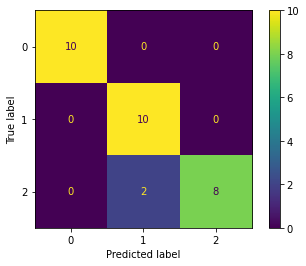

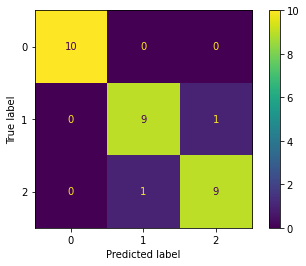

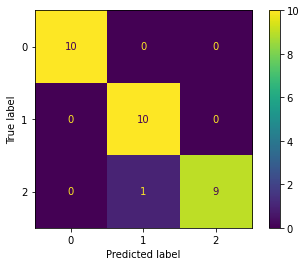

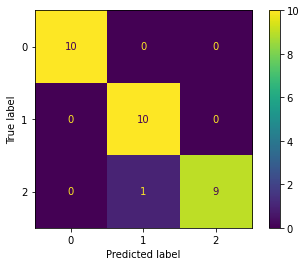

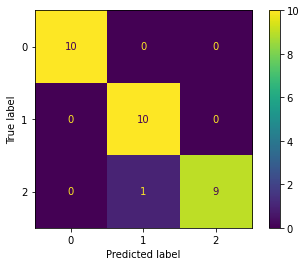

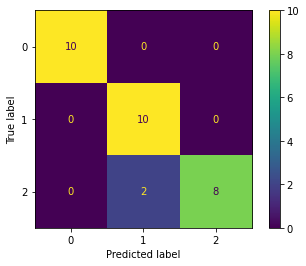

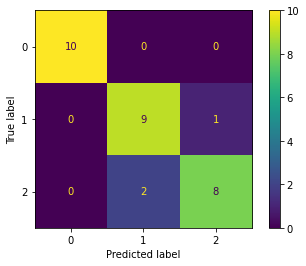

In [11]:
ground_truth = [False, False, True, False, False]
novelty_judgments = []
n_exps = 10

for i in range(n_exps):
    print("========== Experiment %s ==========" % str(i+1))
    
    feature_idxs = [*range(3,16),*range(22,28)]
    #feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
    #feature_idxs = [*range(3,19),*range(22,28)] # with object position
    Xtrain, Ttrain, Xtest, Ttest = make_train_test_data([0,1,3], crop_len, feature_idxs)
    print()

    model = train_classifier(Xtrain, Ttrain, 3)
    print()

    # check classifier on the test data
    classes, probs = model.use(Xtest)

    # make confusion matrix
    cm = sklearn.metrics.confusion_matrix(Ttest, classes)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()

    novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
    novelty_judgments.append(novel_classes)
    
novelty_judgments = np.array(novelty_judgments).reshape(n_exps,-1).T

pred_acc = []
for i in range(len(ground_truth)):
    pred_acc.append(np.sum(novelty_judgments[i] == ground_truth[i])/n_exps)
    print(ground_truth[i], novelty_judgments[i], pred_acc[-1])
    
print(pred_acc, np.mean(pred_acc))

# D: Given cube, sphere, cylinder, and capsule

Test that small cube is not considered to be different from big cube.

========== Experiment 1 ==========
(3600, 19) (3600,) (400, 19) (400,)
(360, 190) (360,) (40, 190) (40,)
(360, 1, 190) (360,) (40, 1, 190) (40,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.049
adam: Epoch 100 Loss 0.022
adam: Epoch 150 Loss 0.017
adam: Epoch 200 Loss 0.014
adam: Epoch 250 Loss 0.013
adam: Epoch 300 Loss 0.011
adam: Epoch 350 Loss 0.009
adam: Epoch 400 Loss 0.011
adam: Epoch 450 Loss 0.011
adam: Epoch 500 Loss 0.007

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.003675401210784912
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0026983022689819336
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimil

adam: Epoch 50 Loss 0.043
adam: Epoch 100 Loss 0.022
adam: Epoch 150 Loss 0.017
adam: Epoch 200 Loss 0.014
adam: Epoch 250 Loss 0.014
adam: Epoch 300 Loss 0.015
adam: Epoch 350 Loss 0.013
adam: Epoch 400 Loss 0.009
adam: Epoch 450 Loss 0.016
adam: Epoch 500 Loss 0.008

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0038158297538757324
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.002168715000152588
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 2
Angle from sim_mean to sim_mean+std: 0.010517597198486328
Angle from sim_mean to new_mean: 0.0
Angle from sim_

adam: Epoch 450 Loss 0.010
adam: Epoch 500 Loss 0.010

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.017671048641204834
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.004471778869628906
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 2
Angle from sim_mean to sim_mean+std: 0.019701838493347168
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 3
Most similar class: 3
Angle from sim_mean to sim_mean+st

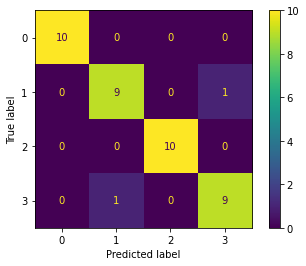

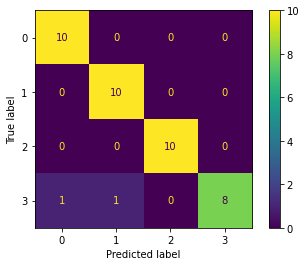

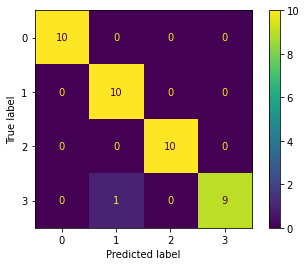

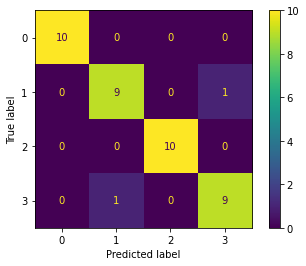

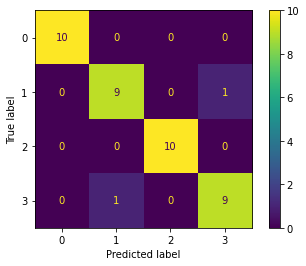

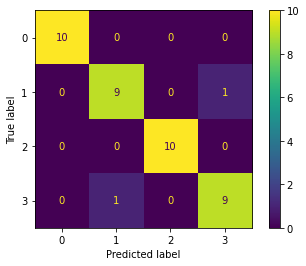

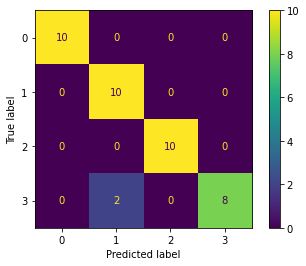

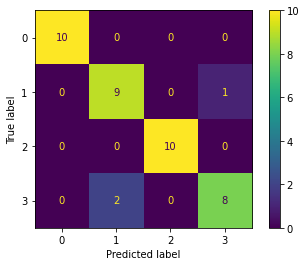

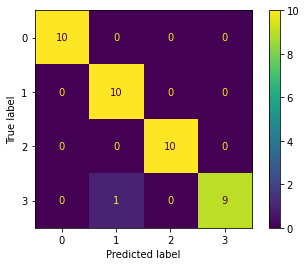

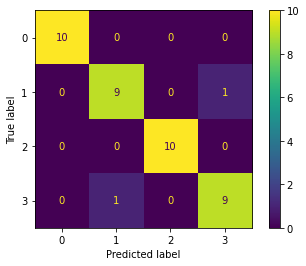

In [12]:
ground_truth = [False, False, False, False, False]
novelty_judgments = []
n_exps = 10

for i in range(n_exps):
    print("========== Experiment %s ==========" % str(i+1))
    
    feature_idxs = [*range(3,16),*range(22,28)]
    #feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
    #feature_idxs = [*range(3,19),*range(22,28)] # with object position
    Xtrain, Ttrain, Xtest, Ttest = make_train_test_data([0,1,2,3], crop_len, feature_idxs)
    print()

    model = train_classifier(Xtrain, Ttrain, 4)
    print()

    # check classifier on the test data
    classes, probs = model.use(Xtest)

    # make confusion matrix
    cm = sklearn.metrics.confusion_matrix(Ttest, classes)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()

    novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
    novelty_judgments.append(novel_classes)
    
novelty_judgments = np.array(novelty_judgments).reshape(n_exps,-1).T

pred_acc = []
for i in range(len(ground_truth)):
    pred_acc.append(np.sum(novelty_judgments[i] == ground_truth[i])/n_exps)
    print(ground_truth[i], novelty_judgments[i], pred_acc[-1])
    
print(pred_acc, np.mean(pred_acc))

# E: Curriculum learning 1

Start with cube and sphere.  After each trial add the class that has inferred to have the *most fine-grained*  dissimilarity from its most similar class above the novelty threshold.  Test for the ability to acquire cylinder and capsule as distinct classes while not splitting small cube from big cube.

========== Experiment 1 ==========
Known classes: [0, 1]
(1800, 19) (1800,) (200, 19) (200,)
(180, 190) (180,) (20, 190) (20,)
(180, 1, 190) (180,) (20, 1, 190) (20,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.000
adam: Epoch 100 Loss 0.000
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.00024569034576416016
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0002014636993408203
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Out

adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.008118629455566406
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0006248354911804199
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.008118629455566406
Angle from sim_mean to new_mean: 2.9385089874267578e

adam: Epoch 50 Loss 0.021
adam: Epoch 100 Loss 0.005
adam: Epoch 150 Loss 0.002
adam: Epoch 200 Loss 0.001
adam: Epoch 250 Loss 0.001
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.005275368690490723
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0043724775314331055
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.005275368690490723
Angle from sim_mean to new_mean: 3.892183303833008e-

adam: Epoch 50 Loss 0.000
adam: Epoch 100 Loss 0.000
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.002071082592010498
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 2.8014183044433594e-06
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.002071082592010498
Angle from sim_mean to new_mean: 2.384185791015625e

adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.023607909679412842
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0002493858337402344
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.023607909679412842
Angle from sim_mean to new_mean: 1.4543533325195312e

adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/sklearn/metrics/_plot/confusion_matrix.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.018290698528289795
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.00017404556274414062
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.018290698528289795
Angle from sim_mean to new_mean: 7.671117782592773e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.00419399935476933
Outlier ratio: 0.9449730494353658
Dissimilarity from most similar class: 2.3784409693810997
Likely novel class: False

New class: 3
Most similar class: 3
Angle from sim_mean to sim_mean+std:

adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.02398437261581421
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0011613965034484863
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.02398437261581421
Angle from sim_mean to new_mean: 6.0617923736572266e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.00252739251126392
Outlier ratio: 1

adam: Epoch 50 Loss 0.003
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.03952443599700928
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0011664628982543945
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.03952443599700928
Angle from sim_mean to new_mean: 0.0002354979515075683

adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.05616956949234009
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0007506608963012695
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.05616956949234009
Angle from sim_mean to new_mean: 0.0003688931465148926

22 4 2 10
adam: Epoch 50 Loss 0.000
adam: Epoch 100 Loss 0.000
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 2.4497509002685547e-05
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.010148167610168457
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 2.4497509002685547e-05
Angle from sim_mean to new_mean: 1.4901

adam: Epoch 50 Loss 0.021
adam: Epoch 100 Loss 0.013
adam: Epoch 150 Loss 0.010
adam: Epoch 200 Loss 0.009
adam: Epoch 250 Loss 0.008
adam: Epoch 300 Loss 0.008
adam: Epoch 350 Loss 0.008
adam: Epoch 400 Loss 0.007
adam: Epoch 450 Loss 0.007
adam: Epoch 500 Loss 0.007

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.004886150360107422
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0019257664680480957
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 2
Angle from sim_mean to sim_mean+std: 0.004853487014770508
Angle from sim_mean to new_mean: 0.0
Angle from sim_

adam: Epoch 50 Loss 0.059
adam: Epoch 100 Loss 0.022
adam: Epoch 150 Loss 0.016
adam: Epoch 200 Loss 0.014
adam: Epoch 250 Loss 0.012
adam: Epoch 300 Loss 0.013
adam: Epoch 350 Loss 0.010
adam: Epoch 400 Loss 0.012
adam: Epoch 450 Loss 0.009
adam: Epoch 500 Loss 0.016

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0074266791343688965
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.005992412567138672
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 2
Angle from sim_mean to sim_mean+std: 0.01053696870803833
Angle from sim_mean to new_mean: 0.0
Angle from sim_m

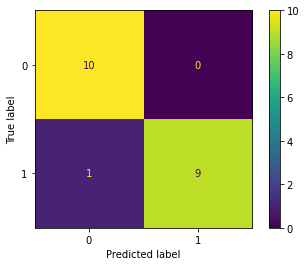

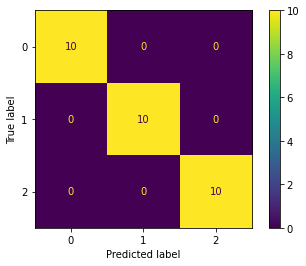

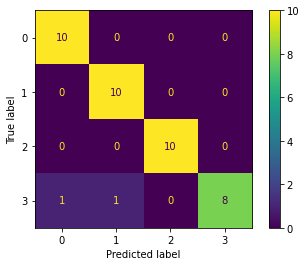

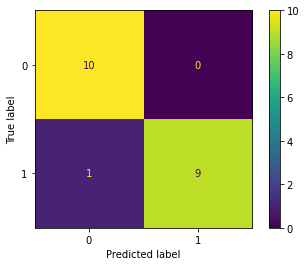

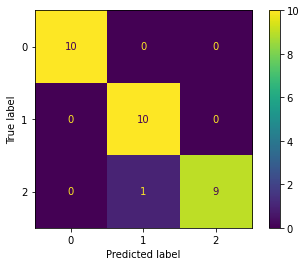

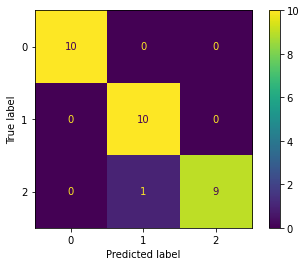

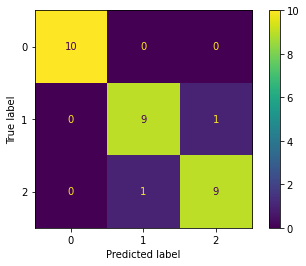

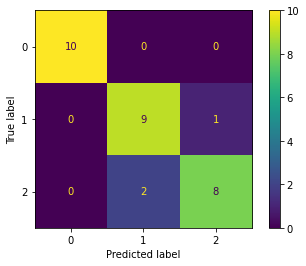

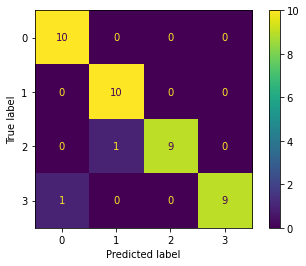

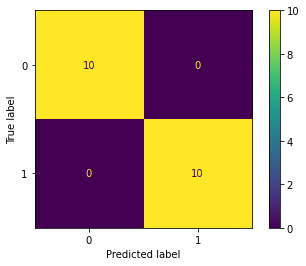

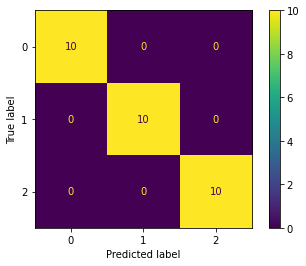

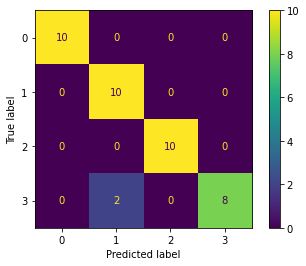

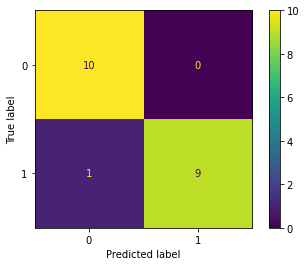

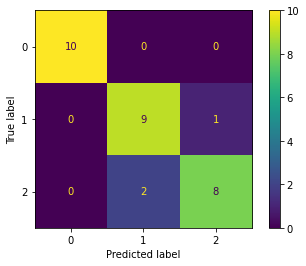

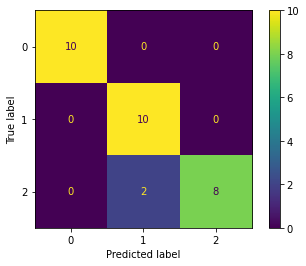

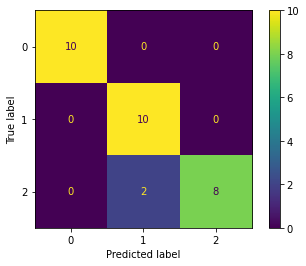

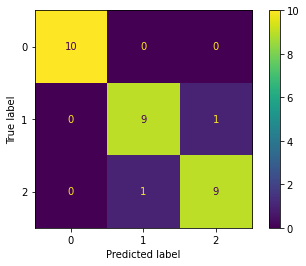

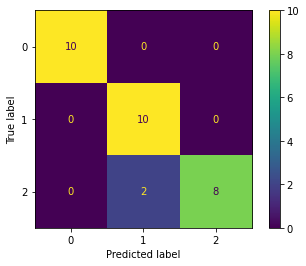

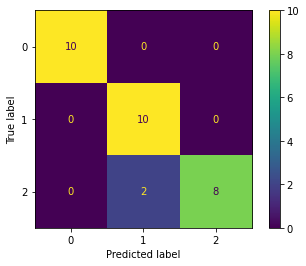

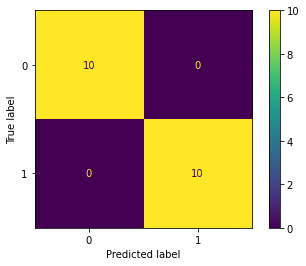

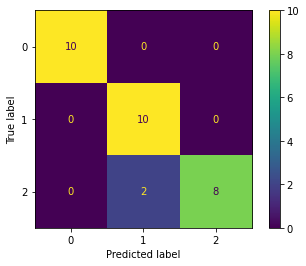

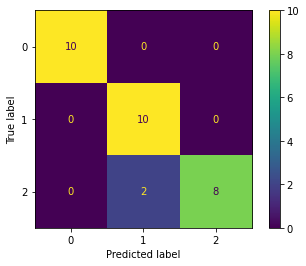

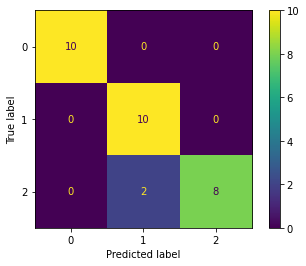

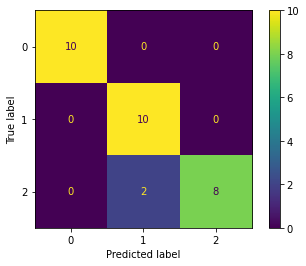

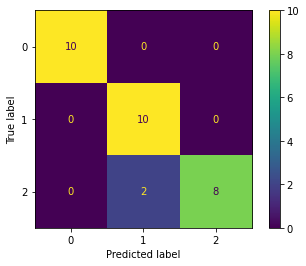

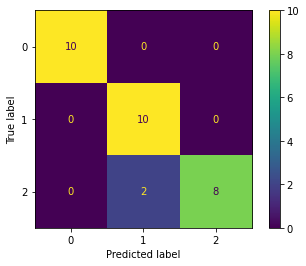

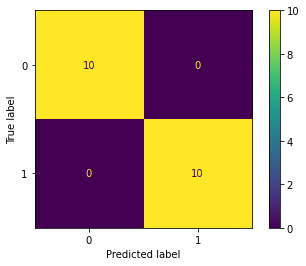

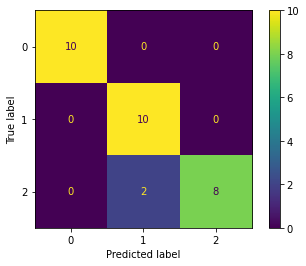

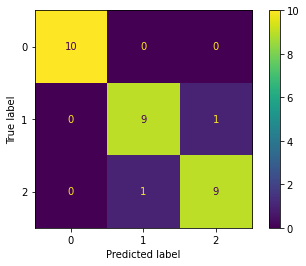

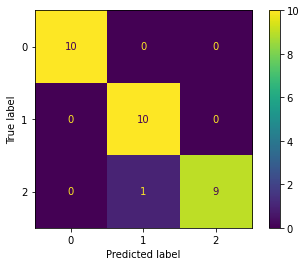

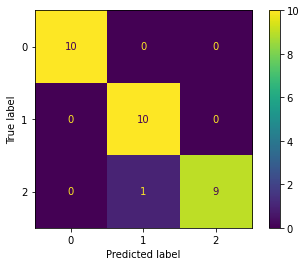

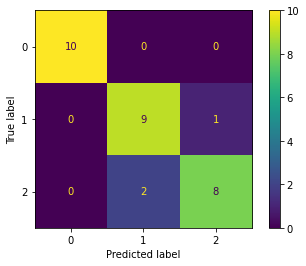

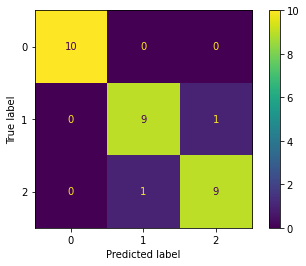

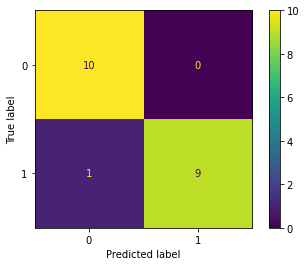

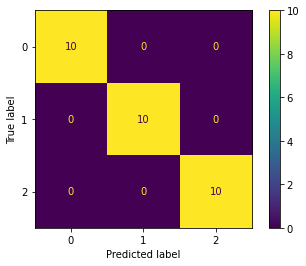

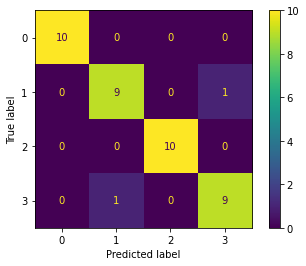

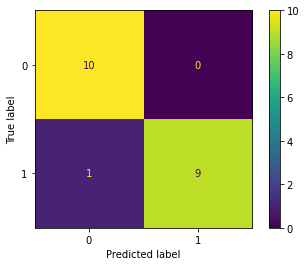

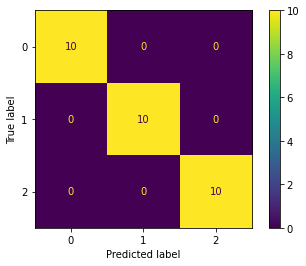

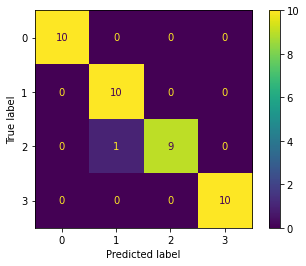

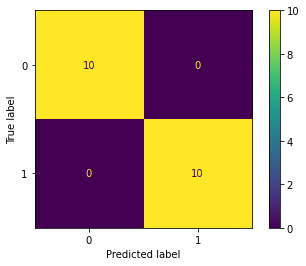

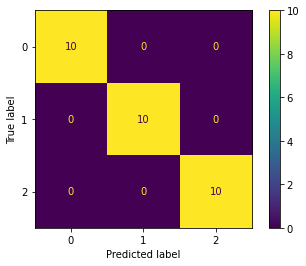

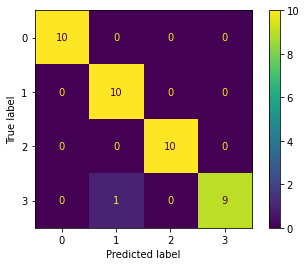

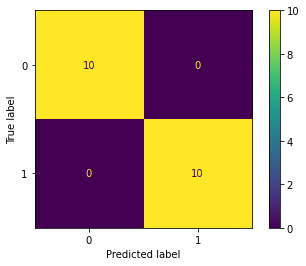

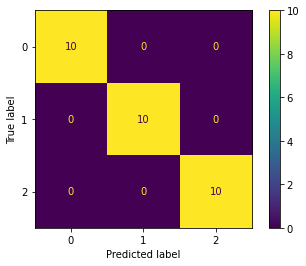

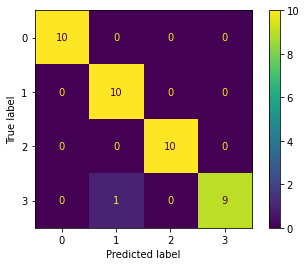

In [14]:
n_exps = 10

ground_truth = [[0,1,2,3]]*n_exps
ground_truth = np.array([np.array(l) for l in ground_truth])

pred_acc = []
for i in range(n_exps):
    print("========== Experiment %s ==========" % str(i+1))
    known_classes = [0,1]
    known_classes_order = []
    
    retrains = 0
    while len(known_classes) < len(ground_truth[-1]) and retrains < 5:
        print("Known classes:", known_classes)
        known_classes_order.append(known_classes.copy())
        
        feature_idxs = [*range(3,16),*range(22,28)]
        #feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
        #feature_idxs = [*range(3,19),*range(22,28)] # with object position
        Xtrain, Ttrain, Xtest, Ttest = make_train_test_data(known_classes, crop_len, feature_idxs)
        print()

        model = train_classifier(Xtrain, Ttrain, len(known_classes))
        print()

        # check classifier on the test data
        classes, probs = model.use(Xtest)

        # make confusion matrix
        cm = sklearn.metrics.confusion_matrix(Ttest, classes)
        disp = ConfusionMatrixDisplay(cm)
        disp.plot()

        novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
        gated_dissimilarities = [dissimilarities[i] if novel_classes[i] == True \
            else float('inf') for i in range(len(dissimilarities))]
        
        if np.min(gated_dissimilarities) == float('inf'):
            print("No novel class found")
            retrains += 1
            print("Retraining (%s)" % retrains)
        else:
            new_class = np.argmin(gated_dissimilarities)
            known_classes.append(new_class)
            retrains = 0

            print("Most novel class:", known_classes[-1])
        print()
        
    print("Known classes:", known_classes)
    known_classes_order.append(known_classes.copy())
    
    feature_idxs = [*range(3,16),*range(22,28)]
    #feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
    #feature_idxs = [*range(3,19),*range(22,28)] # with object position
    Xtrain, Ttrain, Xtest, Ttest = make_train_test_data(known_classes, crop_len, feature_idxs)
    print()

    model = train_classifier(Xtrain, Ttrain, len(known_classes))
    print()

    # check classifier on the test data
    classes, probs = model.use(Xtest)

    # make confusion matrix
    cm = sklearn.metrics.confusion_matrix(Ttest, classes)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()

    novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
    gated_dissimilarities = [dissimilarities[i] if novel_classes[i] == True \
            else float('inf') for i in range(len(dissimilarities))]
    
    if np.min(gated_dissimilarities) != float('inf'):
        new_class = np.argmin(gated_dissimilarities)
        known_classes.append(new_class)
        
    print("Known classes:", known_classes)
    known_classes_order.append(known_classes.copy())
    
    print("Order of acquisition:", known_classes_order)

    pred_acc.append((1-np.sum(np.array(known_classes_order[-1]) == 4))*(len(known_classes_order[-1])/4))
    print(pred_acc,pred_acc[-1])
    
print(np.sum(pred_acc)/len(pred_acc))

# F: Curriculum learning 2

Start with cube and sphere.  After each trial add the class that has inferred to have the *greatest*  dissimilarity from its most similar class above the novelty threshold.  Test for the ability to acquire cylinder and capsule as distinct classes while not splitting small cube from big cube.

========== Experiment 1 ==========
Known classes: [0, 1]
(1800, 19) (1800,) (200, 19) (200,)
(180, 190) (180,) (20, 190) (20,)
(180, 1, 190) (180,) (20, 1, 190) (20,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.000
adam: Epoch 100 Loss 0.000
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.00017058849334716797
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.001245737075805664
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outl

adam: Epoch 50 Loss 0.021
adam: Epoch 100 Loss 0.013
adam: Epoch 150 Loss 0.010
adam: Epoch 200 Loss 0.009
adam: Epoch 250 Loss 0.008
adam: Epoch 300 Loss 0.008
adam: Epoch 350 Loss 0.008
adam: Epoch 400 Loss 0.008
adam: Epoch 450 Loss 0.007
adam: Epoch 500 Loss 0.007

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0013788938522338867
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0004080533981323242
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 2
Angle from sim_mean to sim_mean+std: 0.001044929027557373
Angle from sim_mean to new_mean: 0.0
Angle from sim

adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.01251751184463501
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0007877945899963379
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.01251751184463501
Angle from sim_mean to new_mean: 3.510713577270508e-05

adam: Epoch 50 Loss 0.015
adam: Epoch 100 Loss 0.004
adam: Epoch 150 Loss 0.002
adam: Epoch 200 Loss 0.001
adam: Epoch 250 Loss 0.001
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.009181380271911621
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.004578948020935059
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.009181380271911621
Angle from sim_mean to new_mean: 5.710124969482422e-0

adam: Epoch 50 Loss 0.000
adam: Epoch 100 Loss 0.000
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.00037658214569091797
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 4.786252975463867e-05
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.00037658214569091797
Angle from sim_mean to new_mean: 1.7881393432617

adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/sklearn/metrics/_plot/confusion_matrix.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.03997856378555298
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0004583597183227539
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.03997856378555298
Angle from sim_mean to new_mean: 0.00036662817001342773
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.009170618834134203
Outlier ratio: 0.8971861312198215
Dissimilarity from most similar class: 5.01970659505605
Likely novel class: False

New class: 3
Most similar class: 3
Angle from sim_mean to sim_mean+std: 0.

adam: Epoch 50 Loss 0.020
adam: Epoch 100 Loss 0.013
adam: Epoch 150 Loss 0.010
adam: Epoch 200 Loss 0.009
adam: Epoch 250 Loss 0.008
adam: Epoch 300 Loss 0.008
adam: Epoch 350 Loss 0.008
adam: Epoch 400 Loss 0.007
adam: Epoch 450 Loss 0.007
adam: Epoch 500 Loss 0.007

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0006332993507385254
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0010100007057189941
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 2
Angle from sim_mean to sim_mean+std: 0.0012453794479370117
Angle from sim_mean to new_mean: 0.0
Angle from si

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 5.4895877838134766e-05
Angle from sim_mean to new_mean: 1.1920928955078125e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.002171552660152009
Outlier ratio: 1283.5581989453183
Dissimilarity from most similar class: 553.2379901466682
Likely novel class: True

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.00010317564010620117
Angle from sim_mean to new_mean: 0.00036841630935668945
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 3.5707683419988445
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 5.4895877838134766e-05
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 183.5075873613269
Dissimilarity from most similar class: 0.0
Likely novel class: False

Most novel class: 3

Known classes: [0, 1, 3]
(2700, 19) (2700,) (300, 19) (300,)
(270, 190) (270,) (30, 190) (30,)
(270, 1, 190) (270,) (30, 1, 190) (30,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.03267472982406616
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from

Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.02858865261077881
Angle from sim_mean to new_mean: 7.408857345581055e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.002591537784745996
Outlier ratio: 0.9769648156151286
Dissimilarity from most similar class: 1.4948722150526932
Likely novel class: False

No novel class found
Retraining (4)

Known classes: [0, 1, 3]
(2700, 19) (2700,) (300, 19) (300,)
(270, 190) (270,) (30, 190) (30,)
(270, 1, 190) (270,) (30, 1, 190) (30,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.01899927854537964
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to n

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 2.5331974029541016e-05
Angle from sim_mean to new_mean: 6.556510925292969e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.02588235294117647
Outlier ratio: 12531.211898108342
Dissimilarity from most similar class: 14200.629486505188
Likely novel class: True

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.001377880573272705
Angle from sim_mean to new_mean: 0.003627955913543701
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 2.632997361249297
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 2.5331974029541016e-05
Angle from sim_mean to new_mean: 5.960464477539063e-08
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.002352941176470588
Outlier ratio: 3.108394239036974
Dissimilarity from most similar class: 0.3202269896193771
Likely novel class: False

Most novel class: 3

Known classes: [0, 1, 3]
(2700, 19) (2700,) (300, 19) (300,)
(270, 190) (270,) (30, 190) (30,)
(270, 1, 190) (270,) (30, 1, 190) (30,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.014615893363952637
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_

Angle from sim_mean to sim_mean+std: 0.01810353994369507
Angle from sim_mean to new_mean: 5.3942203521728516e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0029796494878624553
Outlier ratio: 1.3262140595723138
Dissimilarity from most similar class: 2.1586777138977267
Likely novel class: False

No novel class found
Retraining (4)

Known classes: [0, 1, 3]
(2700, 19) (2700,) (300, 19) (300,)
(270, 190) (270,) (30, 190) (30,)
(270, 1, 190) (270,) (30, 1, 190) (30,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0409085750579834
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from si

Angle from sim_mean to sim_mean+std: 0.18092453479766846
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.01695483922958374
Angle from sim_mean to new_mean: 0.0001583695411682129
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.00934066899861138
Outlier ratio: 1.1392218823090214
Dissimilarity from most similar class: 5.937348873283304
Likely novel class: False

No novel class found
Retraining (1)

Known classes: [0, 1, 3]
(2700, 19) (2700,) (300, 19) (300,)
(270, 190) (270,) (30, 190) (30,)
(270, 1, 190) (270,) (30, 1, 190) (30,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0

Angle from sim_mean to sim_mean+std: 0.22782403230667114
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.026411056518554688
Angle from sim_mean to new_mean: 0.00023633241653442383
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.008948237885462555
Outlier ratio: 0.8093746603624296
Dissimilarity from most similar class: 4.368195663073022
Likely novel class: False

No novel class found
Retraining (5)

Known classes: [0, 1, 3]
(2700, 19) (2700,) (300, 19) (300,)
(270, 190) (270,) (30, 190) (30,)
(270, 1, 190) (270,) (30, 1, 190) (30,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Los

Angle from sim_mean to sim_mean+std: 0.0149117112159729
Angle from sim_mean to new_mean: 1.6629695892333984e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0011152104310148416
Outlier ratio: 0.9646119897197174
Dissimilarity from most similar class: 0.5330955624379738
Likely novel class: False

New class: 3
Most similar class: 3
Angle from sim_mean to sim_mean+std: 0.21998578310012817
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0149117112159729
Angle from sim_mean to new_mean: 0.0002014636993408203
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.013510434612294496
Outlier ratio: 1.05235155239062
Dissimilarity from most similar class: 7.04572607754536
Likely novel class: False

No novel class found
Retraining (2)


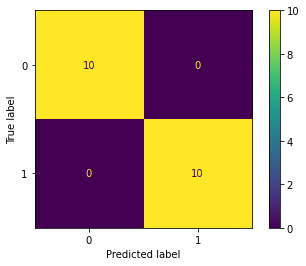

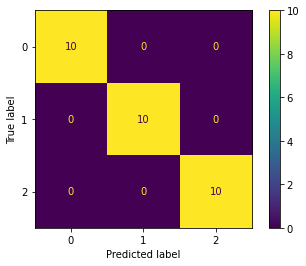

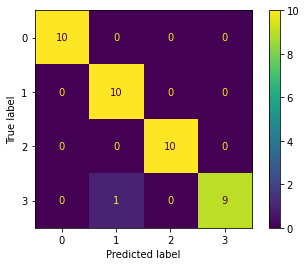

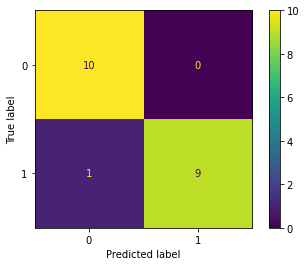

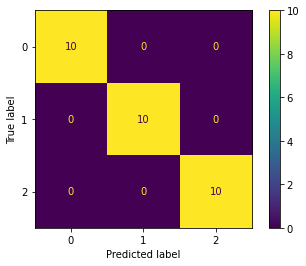

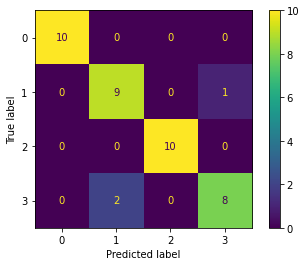

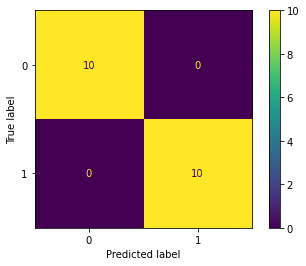

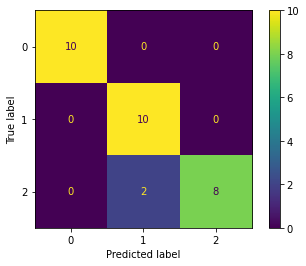

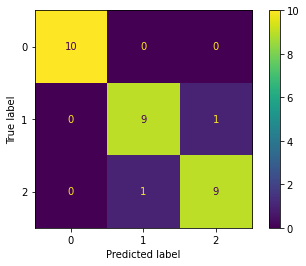

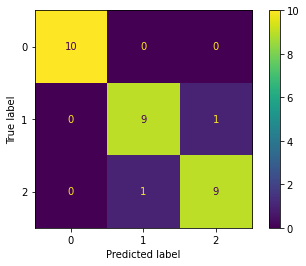

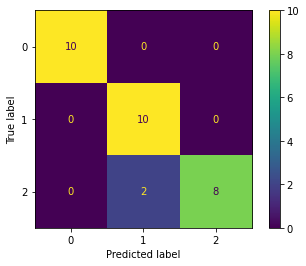

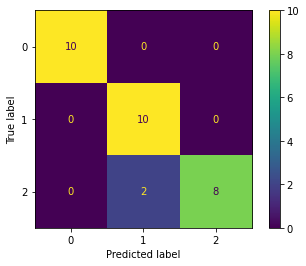

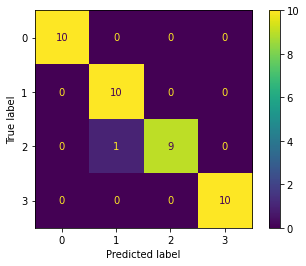

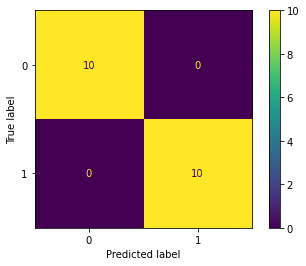

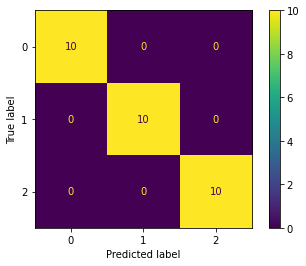

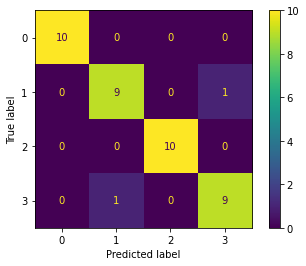

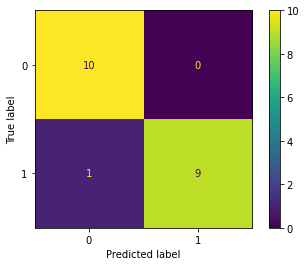

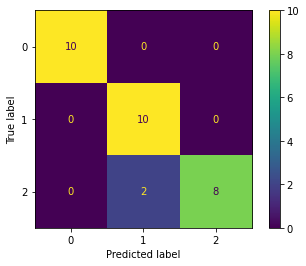

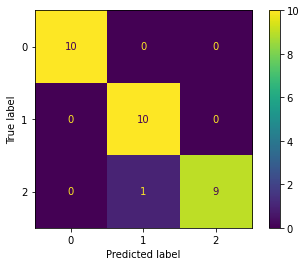

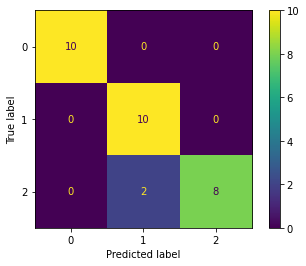

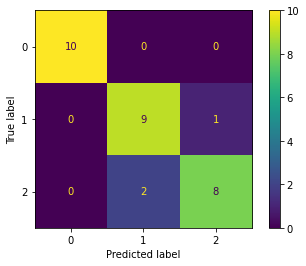

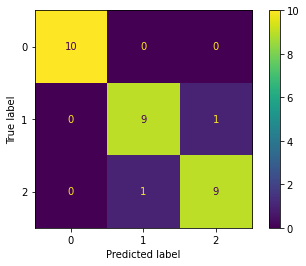

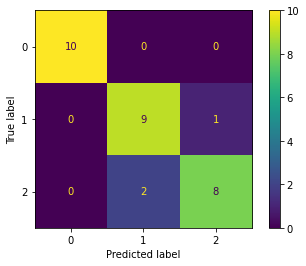

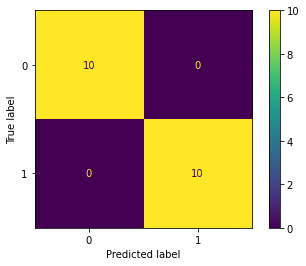

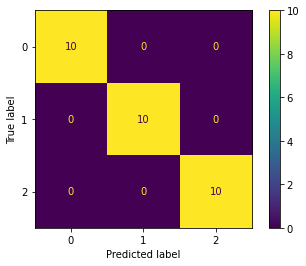

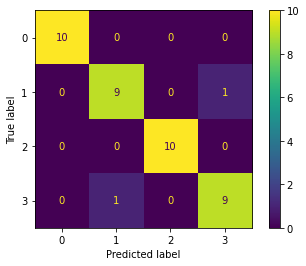

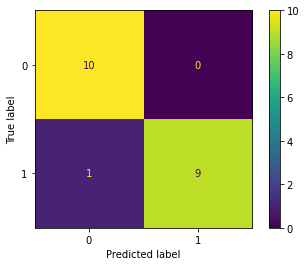

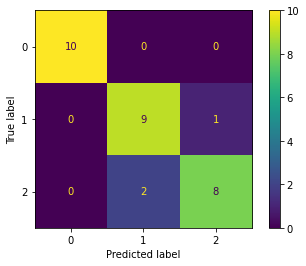

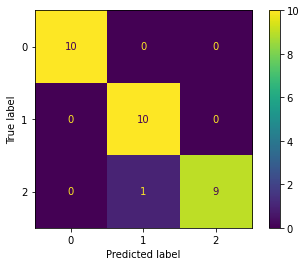

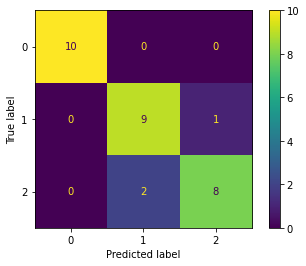

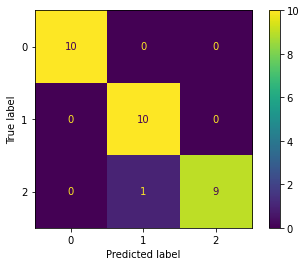

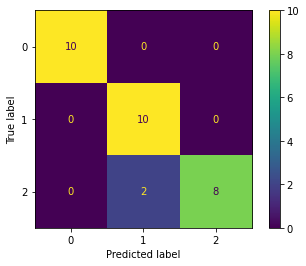

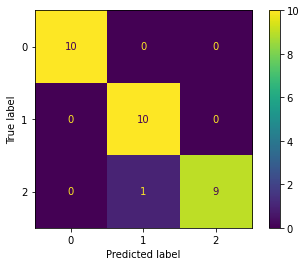

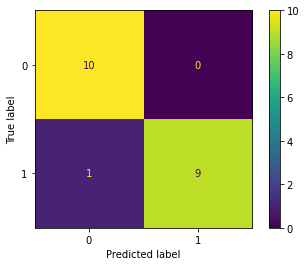

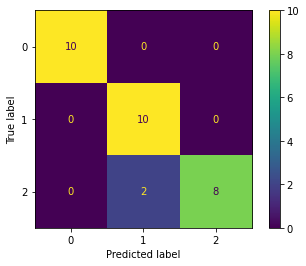

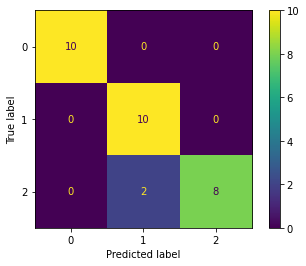

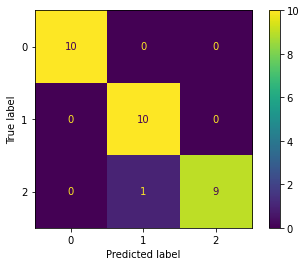

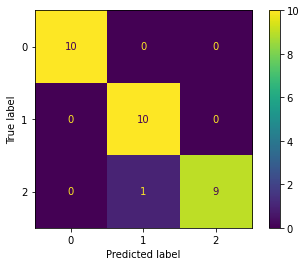

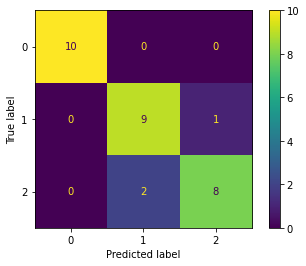

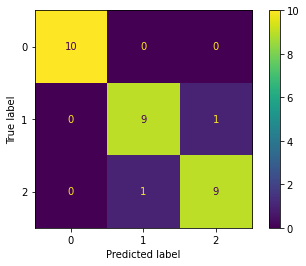

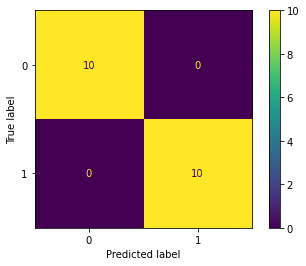

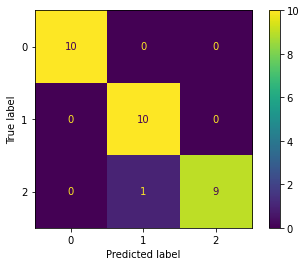

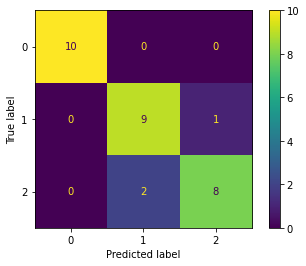

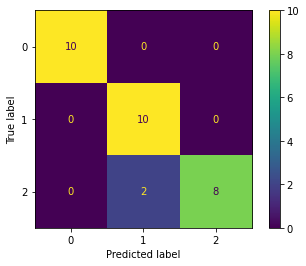

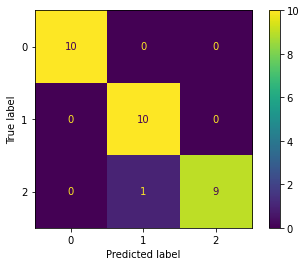

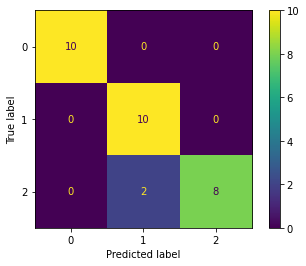

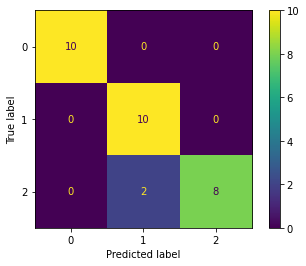

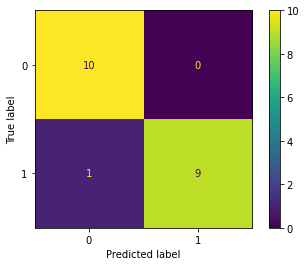

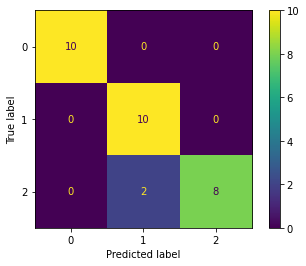

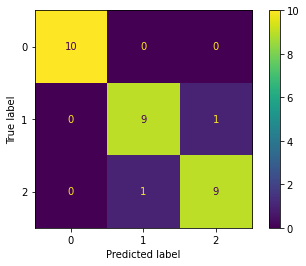

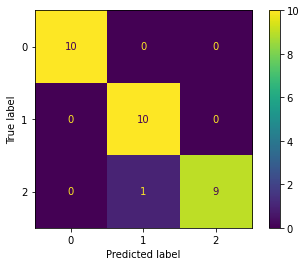

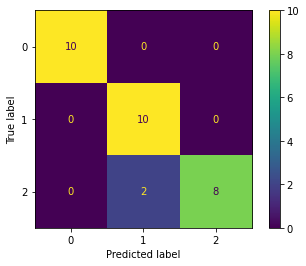

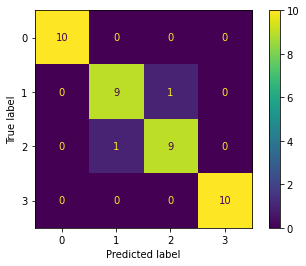

In [15]:
n_exps = 10

ground_truth = [[0,1,2,3]]*n_exps
ground_truth = np.array([np.array(l) for l in ground_truth])

pred_acc = []
for i in range(n_exps):
    print("========== Experiment %s ==========" % str(i+1))
    known_classes = [0,1]
    known_classes_order = []
    
    retrains = 0
    while len(known_classes) < len(ground_truth[-1]) and retrains < 5:
        print("Known classes:", known_classes)
        known_classes_order.append(known_classes.copy())
        
        feature_idxs = [*range(3,16),*range(22,28)]
        #feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
        #feature_idxs = [*range(3,19),*range(22,28)] # with object position
        Xtrain, Ttrain, Xtest, Ttest = make_train_test_data(known_classes, crop_len, feature_idxs)
        print()

        model = train_classifier(Xtrain, Ttrain, len(known_classes))
        print()

        # check classifier on the test data
        classes, probs = model.use(Xtest)

        # make confusion matrix
        cm = sklearn.metrics.confusion_matrix(Ttest, classes)
        disp = ConfusionMatrixDisplay(cm)
        disp.plot()

        novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
        gated_dissimilarities = [dissimilarities[i] if novel_classes[i] == True \
            else float('inf') for i in range(len(dissimilarities))]
        
        if np.min(gated_dissimilarities) == float('inf'):
            print("No novel class found")
            retrains += 1
            print("Retraining (%s)" % retrains)
        else:
            new_class = np.argmin(gated_dissimilarities)
            known_classes.append(new_class)
            retrains = 0

            print("Most novel class:", known_classes[-1])
        print()
        
    print("Known classes:", known_classes)
    known_classes_order.append(known_classes.copy())
    
    feature_idxs = [*range(3,16),*range(22,28)]
    #feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
    #feature_idxs = [*range(3,19),*range(22,28)] # with object position
    Xtrain, Ttrain, Xtest, Ttest = make_train_test_data(known_classes, crop_len, feature_idxs)
    print()

    model = train_classifier(Xtrain, Ttrain, len(known_classes))
    print()

    # check classifier on the test data
    classes, probs = model.use(Xtest)

    # make confusion matrix
    cm = sklearn.metrics.confusion_matrix(Ttest, classes)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()

    novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
    gated_dissimilarities = [dissimilarities[i] if novel_classes[i] == True \
            else float('-inf') for i in range(len(dissimilarities))]
    
    if np.min(gated_dissimilarities) != float('-inf'):
        new_class = np.argmax(gated_dissimilarities)
        known_classes.append(new_class)
        
    print("Known classes:", known_classes)
    known_classes_order.append(known_classes.copy())
    
    print("Order of acquisition:", known_classes_order)

    pred_acc.append((1-np.sum(np.array(known_classes_order[-1]) == 4))*(len(known_classes_order[-1])/4))
    print(pred_acc,pred_acc[-1])
    
print(np.sum(pred_acc)/len(pred_acc))

# G: Given cube and sphere (no VoxML features)

Like (A), but the training data drops the VoxML-derived "jitter" features.

========== Experiment 1 ==========
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.000
adam: Epoch 100 Loss 0.000
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: nan


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/n

Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 9.5367431640625e-07
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 5.960464477539063e-08
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: inf


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in double_scalars


Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 9.5367431640625e-07
Angle from sim_mean to new_mean: 9.5367431640625e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 1.0
Outlier ratio: 15.407176287051483
Dissimilarity from most similar class: 617.25
Likely novel class: True

New class: 4


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 5.960464477539063e-08
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: inf
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

========== Experiment 2 ==========
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.000
adam: Epoch 100 Loss 0.000
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 1.0728836059570312e-06
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from mo

Most similar class: 0
Angle from sim_mean to sim_mean+std: 1.7344951629638672e-05
Angle from sim_mean to new_mean: 5.960464477539063e-08
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.003436426116838488
Outlier ratio: 1.0908293389953334
Dissimilarity from most similar class: 2.0263577425868844
Likely novel class: False

========== Experiment 6 ==========
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.000
adam: Epoch 100 Loss 0.000
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 1.9073486328125e-06
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_me

Angle from sim_mean to sim_mean+std: 4.76837158203125e-07
Angle from sim_mean to new_mean: 5.960464477539063e-08
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.125
Outlier ratio: 1.9679558011049725
Dissimilarity from most similar class: 27.828125
Likely novel class: True

========== Experiment 10 ==========
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.000
adam: Epoch 100 Loss 0.000
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 7.808208465576172e-06
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dis

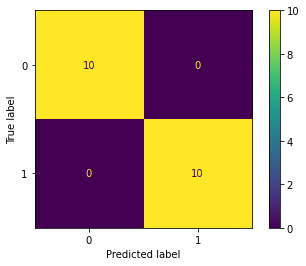

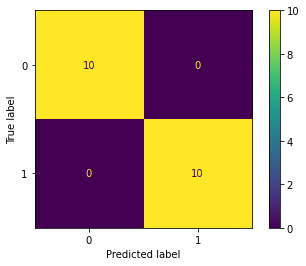

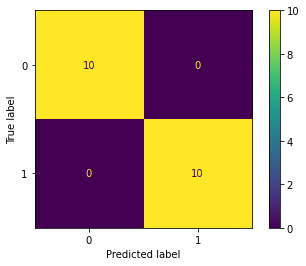

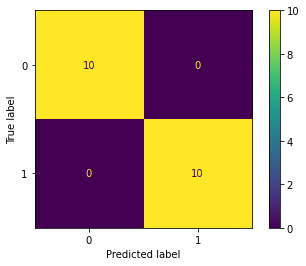

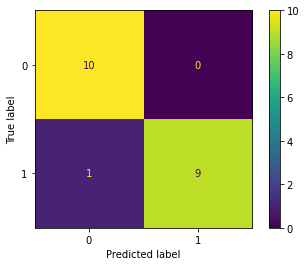

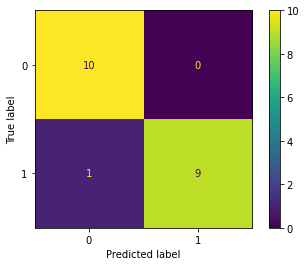

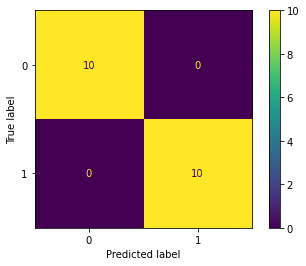

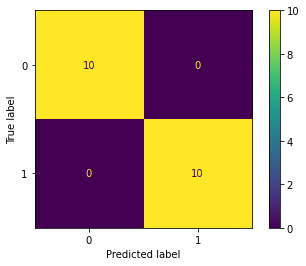

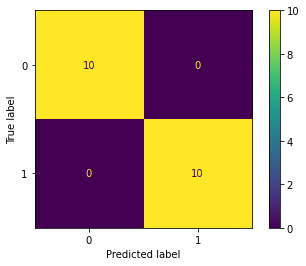

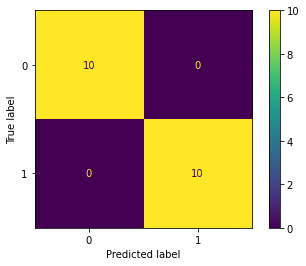

In [16]:
ground_truth = [False, False, True, True, False]
novelty_judgments = []
n_exps = 10

for i in range(n_exps):
    print("========== Experiment %s ==========" % str(i+1))
    
    #feature_idxs = [*range(3,16),*range(22,28)]
    feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
    #feature_idxs = [*range(3,19),*range(22,28)] # with object position
    Xtrain, Ttrain, Xtest, Ttest = make_train_test_data([0,1], crop_len, feature_idxs)
    print()

    model = train_classifier(Xtrain, Ttrain, 2)
    print()

    # check classifier on the test data
    classes, probs = model.use(Xtest)

    # make confusion matrix
    cm = sklearn.metrics.confusion_matrix(Ttest, classes)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()

    novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
    novelty_judgments.append(novel_classes)
    
novelty_judgments = np.array(novelty_judgments).reshape(n_exps,-1).T

pred_acc = []
for i in range(len(ground_truth)):
    pred_acc.append(np.sum(novelty_judgments[i] == ground_truth[i])/n_exps)
    print(ground_truth[i], novelty_judgments[i], pred_acc[-1])
    
print(pred_acc, np.mean(pred_acc))